# temps de debut execution

In [4]:
import time
import datetime

# Marquer le début de l'exécution
start_time = time.time()
print(f"Exécution du notebook commencée à: {datetime.datetime.now()}")


Exécution du notebook commencée à: 2024-06-27 10:02:00.170821


# Préparation des données

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import joblib
import os

# Configurer MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Credit Risk Model")

# Charger le DataFrame
app_datas = pd.read_csv('../csv_files/app_datas_light.csv')

# Mode débogage
debug_mode = True

if debug_mode:
    # Utiliser un sous-ensemble du dataset pour le débogage
    app_datas = app_datas.sample(frac=0.01, random_state=42)

# Séparer les features et la cible
X = app_datas.drop(columns=['TARGET'])
y = app_datas['TARGET']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Créer un pipeline avec imputation KNN, standardisation et SMOTE
pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=3)),  # Imputation des valeurs manquantes
    ('scaler', StandardScaler()),  # Standardisation des caractéristiques
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42))  # Équilibrage des classes avec SMOTE
])

# Appliquer le pipeline sur les données d'entraînement
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Transformer les données de test sans SMOTE
X_test_imputed = pipeline.named_steps['imputer'].transform(X_test)
X_test_scaled = pipeline.named_steps['scaler'].transform(X_test_imputed)

print(f"Shape of X_train: {X_train_resampled.shape}")
print(f"Shape of X_test: {X_test_scaled.shape}")
print(f"Distribution in y_train: {pd.Series(y_train_resampled).value_counts(normalize=True)}")
print(f"Distribution in y_test: {pd.Series(y_test).value_counts(normalize=True)}")


Shape of X_train: (2943, 240)
Shape of X_test: (615, 240)
Distribution in y_train: TARGET
0    0.769283
1    0.230717
Name: proportion, dtype: float64
Distribution in y_test: TARGET
0    0.920325
1    0.079675
Name: proportion, dtype: float64


In [6]:
app_datas['SK_ID_CURR']


245895    368274
98194     141653
36463     289560
249923    256074
158389    396861
           ...  
27160     340289
159114    281065
73893     193365
5706      303327
178694    343944
Name: SK_ID_CURR, Length: 3075, dtype: int64

# Modélisation

## fonction model

In [7]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

def evaluate_and_log_model(model, model_name, model_type, params, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Entraîner le modèle
        model.fit(X_train, y_train)

        # Prédictions
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Évaluer les performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn

        # Logger les métriques et les hyperparamètres
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        mlflow.log_params(params)
        mlflow.log_param("model_type", model_type)
        
        # Enregistrer le modèle
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"{model_name} - AUC: {auc}")
        print(f"{model_name} - Accuracy: {accuracy}")
        print(f"{model_name} - Cost: {cost}")


## Modèle Dummy

In [8]:
from sklearn.dummy import DummyClassifier

dummy_params = {"strategy": "most_frequent"}
dummy_clf = DummyClassifier(**dummy_params)
evaluate_and_log_model(dummy_clf, "dummy_classifier_model", "Dummy Classifier", dummy_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


dummy_classifier_model - AUC: 0.5
dummy_classifier_model - Accuracy: 0.9203252032520325
dummy_classifier_model - Cost: 490


## Modèle Regression lineaire

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg_params = {
    "penalty": 'l2',
    "C": 1.0,
    "class_weight": 'balanced',
    "random_state": 42,
    "max_iter": 1000
}
log_reg = LogisticRegression(**log_reg_params)
evaluate_and_log_model(log_reg, "logistic_regression_model", "Logistic Regression", log_reg_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


logistic_regression_model - AUC: 0.6059710103122522
logistic_regression_model - Accuracy: 0.7317073170731707
logistic_regression_model - Cost: 417


## Modèle Random Forrest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    "n_estimators": 100,
    "class_weight": 'balanced',
    "random_state": 42
}
rf_clf = RandomForestClassifier(**rf_params)
evaluate_and_log_model(rf_clf, "random_forest_model", "Random Forest", rf_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


random_forest_model - AUC: 0.6414689550731953
random_forest_model - Accuracy: 0.9186991869918699
random_forest_model - Cost: 491


## Modèle XGBoost

In [11]:
from xgboost import XGBClassifier

xgb_params = {
    "objective": 'binary:logistic',
    "random_state": 42,
    "eval_metric": 'auc'
}
xgb_clf = XGBClassifier(**xgb_params)
evaluate_and_log_model(xgb_clf, "xgboost_model", "XGBoost", xgb_params, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


xgboost_model - AUC: 0.7029999278863489
xgboost_model - Accuracy: 0.9105691056910569
xgboost_model - Cost: 478


## création du score personnalisé

In [12]:
from sklearn.metrics import make_scorer, confusion_matrix

# Définir une fonction pour calculer le coût
def custom_cost(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    fp = conf_matrix[0][1]
    fn = conf_matrix[1][0]
    cost = fp + 10 * fn
    return cost

# Créer un make_scorer à partir de la fonction custom_cost
cost_scorer = make_scorer(custom_cost, greater_is_better=False)


## Gridsearchcv sur XGBOost et log mlflow

In [13]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np

# Définir les hyperparamètres à tester
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300]
}

# Créer le modèle XGBoost
xgb_clf = XGBClassifier(objective='binary:logistic', random_state=42)

# Configurer GridSearchCV avec le score personnalisé
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring=cost_scorer, cv=3, verbose=2, n_jobs=-1)

# Fonction pour évaluer et enregistrer les résultats de GridSearchCV dans MLflow
def log_grid_search_cv_results(grid_search, X_train, y_train, X_test, y_test):
    with mlflow.start_run():
        # Loguer le type de modèle
        mlflow.log_param("model_type", "XGBoost with GridSearchCV")
        
        # Entraîner le GridSearchCV
        grid_search.fit(X_train, y_train)
        
        # Logger tous les résultats de GridSearchCV
        cv_results = pd.DataFrame(grid_search.cv_results_)
        for i in range(len(cv_results)):
            for key in cv_results.columns:
                value = cv_results[key].iloc[i]
                if isinstance(value, (float, int, np.number)):
                    mlflow.log_metric(f"{key}_{i}", value)
                elif isinstance(value, (list, dict)):
                    # Convert lists or dicts to a string representation
                    mlflow.log_param(f"{key}_{i}", str(value))
        
        # Enregistrer les meilleurs hyperparamètres
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)
       
        
        # Afficher les meilleurs hyperparamètres
        print("Best Hyperparameters:", best_params)
        
        # Enregistrer le meilleur modèle
        best_model = grid_search.best_estimator_
        mlflow.sklearn.log_model(best_model, "best_xgboost_model")

        # Sauvegarder le modèle localement dans le dossier 'models'
        model_path = '../models/best_xgboost_model.pkl'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        joblib.dump(best_model, model_path)
        print(f"Best model saved to {model_path}")
        
        # Prédictions avec le meilleur modèle
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:, 1]
        
        # Évaluer les performances
        auc = roc_auc_score(y_test, y_proba)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        fp = conf_matrix[0][1]
        fn = conf_matrix[1][0]
        cost = fp + 10 * fn
        
        # Logger les métriques
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Cost", cost)
        
        print(f"Best Model - AUC: {auc}")
        print(f"Best Model - Accuracy: {accuracy}")
        print(f"Best Model - Cost: {cost}")

# Exécuter la fonction pour loguer les résultats de GridSearchCV
log_grid_search_cv_results(grid_search, X_train_resampled, y_train_resampled, X_test_scaled, y_test)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}
Best model saved to ../models/best_xgboost_model.pkl
Best Model - AUC: 0.6959327900771616
Best Model - Accuracy: 0.9105691056910569
Best Model - Cost: 496


## descriptions features

In [14]:
# Charger le fichier de description des colonnes avec l'encodage correct
try:
    columns_description = pd.read_csv('../csv_files/HomeCredit_columns_description.csv', encoding='utf-8')
except UnicodeDecodeError:
    columns_description = pd.read_csv('../csv_files/HomeCredit_columns_description.csv', encoding='ISO-8859-1')

# Filtrer pour obtenir uniquement les descriptions pertinentes pour les caractéristiques utilisées dans l'application {train|test}
feature_descriptions = columns_description[columns_description['Table'].str.contains('application_{train|test}.csv', na=False)]
feature_descriptions = feature_descriptions[['Row', 'Description']].set_index('Row')


# Feature importance

## globale

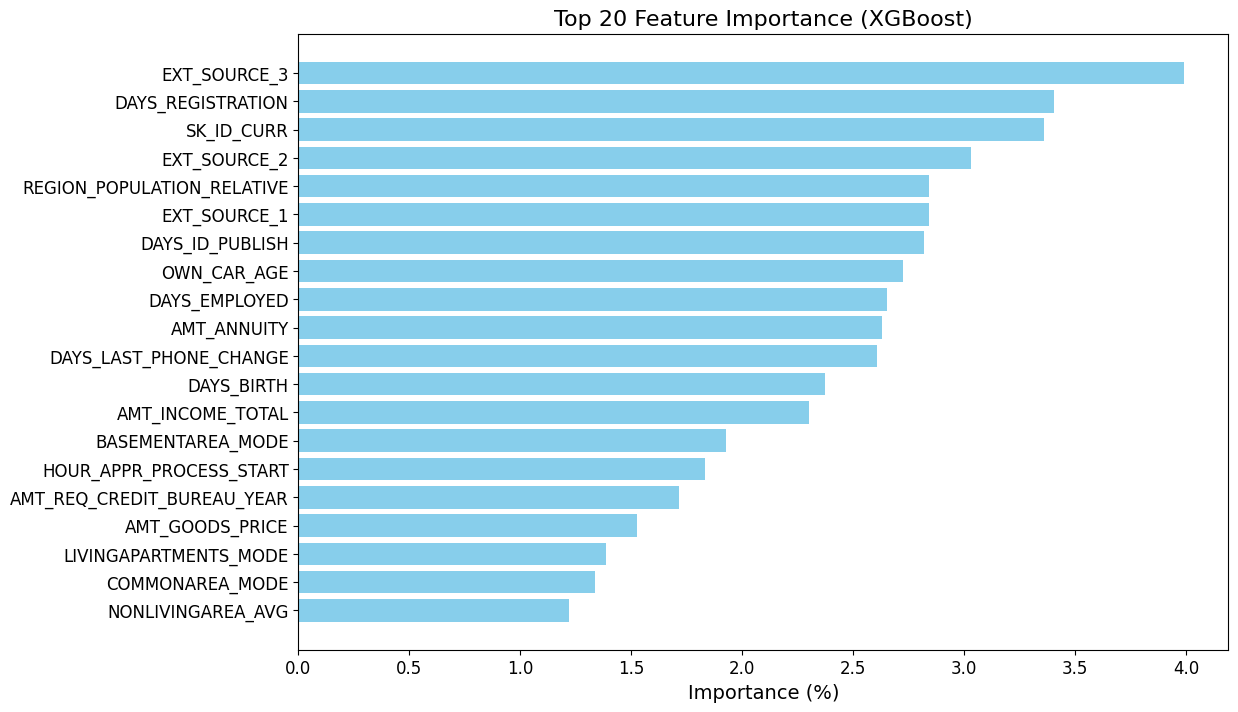

EXT_SOURCE_3: Normalized score from external data source
DAYS_REGISTRATION: How many days before the application did client change his registration
SK_ID_CURR: ID of loan in our sample
EXT_SOURCE_2: Normalized score from external data source
REGION_POPULATION_RELATIVE: Normalized population of region where client lives (higher number means the client lives in more populated region)
EXT_SOURCE_1: Normalized score from external data source
DAYS_ID_PUBLISH: How many days before the application did client change the identity document with which he applied for the loan
OWN_CAR_AGE: Age of client's car
DAYS_EMPLOYED: How many days before the application the person started current employment
AMT_ANNUITY: Loan annuity
DAYS_LAST_PHONE_CHANGE: How many days before application did client change phone
DAYS_BIRTH: Client's age in days at the time of application
AMT_INCOME_TOTAL: Income of the client
BASEMENTAREA_MODE: Normalized information about building where the client lives, What is average (_A

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBClassifier, plot_importance

# Entraîner le meilleur modèle XGBoost avec les meilleurs hyperparamètres trouvés
best_model = grid_search.best_estimator_

# Extraire l'importance des caractéristiques
importance = best_model.get_booster().get_score(importance_type='weight')

# Convertir en DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# Assigner des noms significatifs aux features basées sur leur ordre dans les données d'origine
feature_names = X_train.columns
importance_df['Feature'] = importance_df['Feature'].apply(lambda x: feature_names[int(x[1:])])

# Ajouter les descriptions des caractéristiques
importance_df['Description'] = importance_df['Feature'].map(feature_descriptions['Description'])

# Remplacer les valeurs NaN dans les descriptions par une chaîne vide pour éviter les erreurs
importance_df['Description'] = importance_df['Description'].fillna('')

# Trier les caractéristiques par importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Calculer le pourcentage d'importance
importance_df['Importance'] = 100 * (importance_df['Importance'] / importance_df['Importance'].sum())

# Afficher les 20 premières caractéristiques
top_20_features = importance_df.head(20)

plt.figure(figsize=(12, 8))  # Ajustez la taille de la figure pour plus de lisibilité
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance (%)', fontsize=14)
plt.title('Top 20 Feature Importance (XGBoost)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()

# Afficher le graphique
plt.show()

# Afficher les descriptions des 20 premières caractéristiques
descriptions = [f"{feature}: {desc}" for feature, desc in zip(top_20_features['Feature'], top_20_features['Description'])]

# Utiliser print pour afficher les descriptions
for description in descriptions:
    print(description)


## locale

/home/alexandre/anaconda3/envs/stabadenvP7/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Crédit accepté


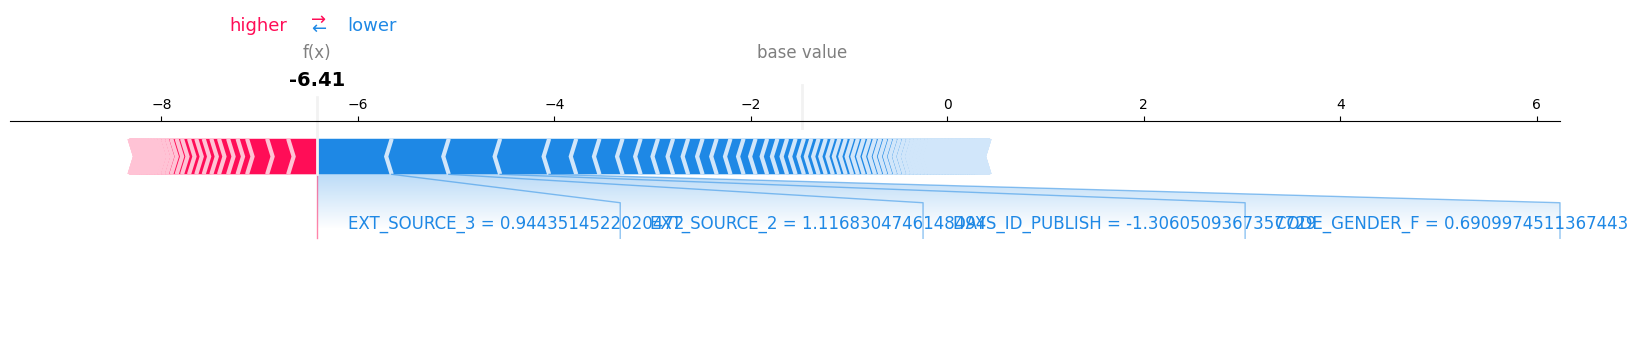

Crédit refusé


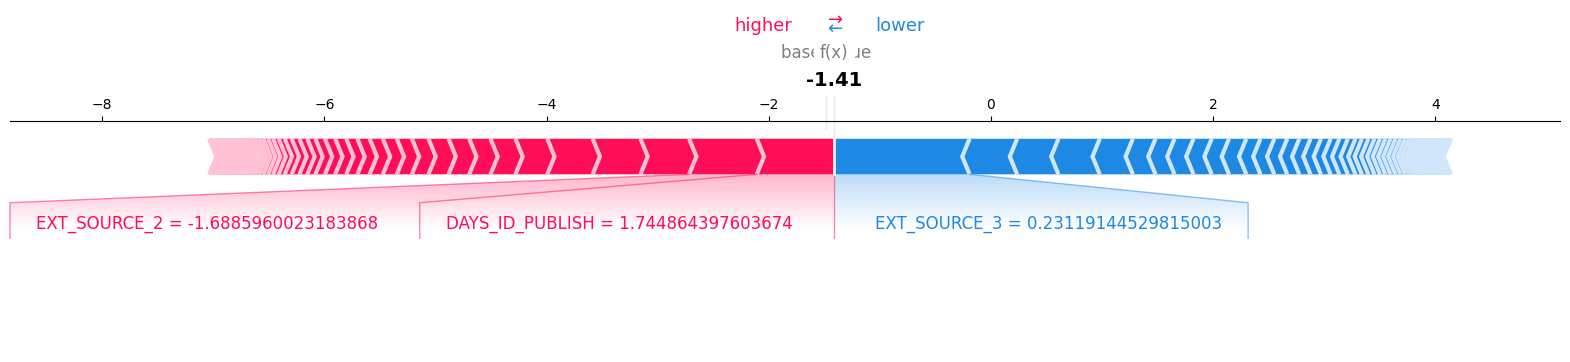

In [16]:
import shap

# Créer un explainer SHAP pour le modèle XGBoost
explainer = shap.TreeExplainer(best_model)

# Sélectionner un client avec une cible de 0 et un client avec une cible de 1
indices_target_0 = y_test[y_test == 0].index
indices_target_1 = y_test[y_test == 1].index

# Vérifier que les indices existent
if len(indices_target_0) > 0:
    index_target_0 = indices_target_0[0]
    # Convertir l'index global en index relatif
    relative_index_target_0 = y_test.index.get_loc(index_target_0)
    X_target_0 = X_test_scaled[relative_index_target_0].reshape(1, -1)
    shap_values_target_0 = explainer.shap_values(X_target_0)
    
    # Afficher l'analyse SHAP pour un client avec une cible de 0
    print("Crédit accepté")
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values_target_0, X_target_0, feature_names=feature_names, matplotlib=True)

if len(indices_target_1) > 0:
    index_target_1 = indices_target_1[0]
    # Convertir l'index global en index relatif
    relative_index_target_1 = y_test.index.get_loc(index_target_1)
    X_target_1 = X_test_scaled[relative_index_target_1].reshape(1, -1)
    shap_values_target_1 = explainer.shap_values(X_target_1)
    
    # Afficher l'analyse SHAP pour un client avec une cible de 1
    print("Crédit refusé")
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values_target_1, X_target_1, feature_names=feature_names, matplotlib=True)


# temps de fin d'execution

In [17]:
# Marquer la fin de l'exécution
end_time = time.time()

# Calculer le temps d'exécution total
execution_time = end_time - start_time
execution_time_str = str(datetime.timedelta(seconds=execution_time))

print(f"Exécution du notebook terminée à: {datetime.datetime.now()}")
print(f"Temps d'exécution total: {execution_time_str}")


Exécution du notebook terminée à: 2024-06-27 10:02:59.329617
Temps d'exécution total: 0:00:59.158754
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   3.9s
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=200; total time=  21.3s
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=300; total time=  11.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=200; total time=   8.3s
[CV] END ..learning_rate=0.01, max_depth=9, n_estimators=300; total time=  28.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.6s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=300; total time=  12.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   2.3s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=   3.3s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=300; total time=   8.4s
[CV] END